# Solar System Objects in a field of view

The purpose of the tutorial is to retrieve data from an API (Application Programming Interface).
Once you will have done it once, you will see that 

1. it's easy!
2. many Web services in astronomy can be accessed by adapting the code here below. 


To illustrate the query, we will search for all Solar System objects in a field of view. In the
<a href="https://www.ivoa.net/">Virtual Observatory</a> terminology, this is called a
<kbd><a href="https://www.ivoa.net/documents/latest/ConeSearch.html">cone-search</a></kbd>.

We must specify the direction (**coordinates**) at which we are pointing at, and a **radius** around to search for targets. As Solar System objects constantly move, the **epoch** of observation is also required. The general philosophy is to provide all the parameters as keywords (in a <kbd>param=value</kbd> fashion) to the URL of the service, which returns the answer. 

<kbd><a href="https://www.ivoa.net/documents/latest/ConeSearch.html">cone-search</a></kbd> are core services in the
<a href="https://www.ivoa.net/">Virtual Observatory</a> for fixed objects (stars, galaxies, ...). They are, however, only a few for Solar System:

- **MPChecker** of the [Minor Planet Center](https://minorplanetcenter.net), available in [Web form](https://minorplanetcenter.net/cgi-bin/checkmp.cgi) only
- **SkyBoT** of the [IMCCE](https://www.imcce.fr/), available in [Aladin](https://aladin.cds.unistra.fr/) and with an [API](https://ssp.imcce.fr/webservices/skybot/)
- **Small-Body Identification Tool** of the [JPL Solar System Dynamics](https://ssd.jpl.nasa.gov/), available in [Web form](https://ssd.jpl.nasa.gov/tools/sb_ident.html) and [API](https://ssd-api.jpl.nasa.gov/doc/sb_ident.html)

We will use **SkyBoT** here.

In [1]:
import io
import requests
from astropy.coordinates import Angle

import pandas as pd

import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord

## Define the parameters of the query

All services with an API have a documentation explaining how to use them. For a complete description of the parameters, we highly recommend to look at the documentation:
[https://ssp.imcce.fr/webservices/skybot/api/conesearch/](https://ssp.imcce.fr/webservices/skybot/api/conesearch/)

In [2]:
# When we observe
epoch = "2022-06-21T00:00:00"

# Where we observe
ra = "07h08m00"
dec = "+26d34m00"
radius = 0.25

# Where are we observing from (observatory IAU code)
observer = "500"

# Filename to store results
filename = "my_conesearch.csv"

## Build the query parameters

This step will be very similar for all APIs you query: you specify the URL of the service and create a `dict` containing the parameter-value pairs you want to pass to the request.

In [3]:
# Service URL
url = "https://ssp.imcce.fr/webservices/skybot/api/conesearch.php?"

# Query parameters
# The request package that we will use will create the full URL for us from the dictionary below
params = {
    "-ep": epoch,
    "-ra": Angle(ra).degree,
    "-dec": Angle(dec).degree,
    "-sr": radius,
    "-mime": "json",
    "-output": "all",
    "-loc": observer,
    "-tscale": "UTC",
    'objFilter': '110'
}

## Querying the service

The critical part in the code below is the `requests.post` line, which executes an HTTP POST request, used to send data to a server. We wrap it in a try-except block because sometimes, servers do not respond in time, and the request times out with an error.

In [4]:
try:
    r = requests.post(url, params=params, timeout=2000)
except requests.exceptions.ReadTimeout:
    print("Request timed out")

That's it! Easy isn't it?

The variable <kbd>r</kbd> contains the results of the <kbd><a href="https://www.ivoa.net/documents/latest/ConeSearch.html">cone-search</a></kbd>. We can extract its content and write it to disk for later usage if needed (*disk access generally slows codes*). 

## Reading the results

The `io.BytesIO` function is a neat little trick to create a "file-like" object in `python` that we can pass to functions like `read_json`. Alternatively, we can write the file to disk and pass the filename to `read_json`.

In [5]:
# Read results in a pandas DataFrame
data = pd.read_json(io.BytesIO(r.content))

In [6]:
# Inspect the results, brightest first
data.sort_values(by="VMag (mag)").head()

,Num,Name,RA (deg),DEC (deg),Class,VMag (mag),Err (arcsec),d (arcsec),dRA (arcsec/h),dDEC (arcsec/h),dg (ua),dh (ua),Phase (deg),SunElong (deg),position (au),velocity (au/d),ref_epoch
1,1,Ceres,07 08 11.2652,+26 34 20.546,MB>Middle,8.7,0.049,152.523,65.1163,-4.1055,3.556523,2.597565,6.34,163.60,"{'x': -0.9298176570000001, 'y': 2.116009344, '...","{'x': -0.009859299, 'y': -0.004849444000000000...",2459750
3,297,Caecilia,07 08 11.9211,+26 31 10.539,MB>Outer,15.6,0.016,233.039,47.3915,-7.7274,4.463662,3.500562,4.70,163.60,"{'x': -1.170556571, 'y': 2.888540183, 'z': 1.5...","{'x': -0.008413383, 'y': -0.001594882000000000...",2459750
28,16821,1997 VZ4,07 08 28.1267,+26 24 47.011,MB>Inner,19.9,0.028,669.617,60.5580,-6.3462,3.634592,2.675466,6.17,163.56,"{'x': -0.95657481, 'y': 2.182925112, 'z': 1.21...","{'x': -0.009083585, 'y': -0.002840859000000000...",2459750
16,348135,2004 BW110,07 08 27.8412,+26 39 45.398,MB>Middle,20.8,0.120,508.630,69.6639,-15.5832,3.343538,2.386511,6.94,163.53,"{'x': -0.875895921, 'y': 1.928733813, 'z': 1.1...","{'x': -0.010414373000000001, 'y': -0.003596369...",2459750
33,107506,2001 DM49,07 07 33.2570,+26 44 48.990,MB>Inner,20.9,0.114,741.431,76.8215,-7.5444,3.126633,2.169981,7.55,163.72,"{'x': -0.807120813, 'y': 1.747307962, 'z': 1.0...","{'x': -0.010759032, 'y': -0.005316503, 'z': -0...",2459750


## Writing the results to disk

In [7]:
# Write results
data.to_csv(filename, index=False)

## Plot the results

In [8]:
# Convert RA/Dec from hours/degrees to degrees
coords = SkyCoord(data["RA (deg)"], data["DEC (deg)"], unit=("hour", "deg"))

data["RA"] = coords.ra.degree
data["DEC"] = coords.dec.degree

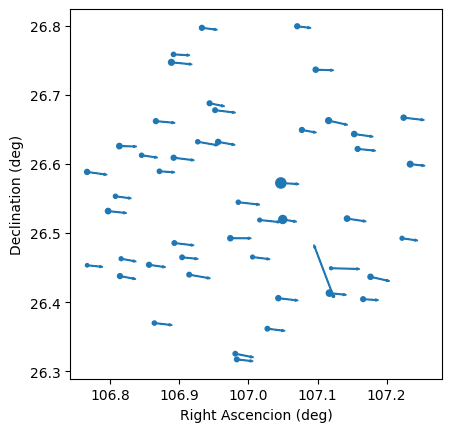

In [9]:
# Create a figure and axe objects
fig, ax = plt.subplots()

# Plot the asteroids (size is inversely proportional to magnitude)
ax.scatter(data["RA"], data["DEC"], s=80 - 3 * data["VMag (mag)"], color="C0")

# Show the arrows of motion
scale = 3000  # Visual scaling factor for the arrows
for i, row in data.iterrows():
    ax.arrow(
        row["RA"],
        row["DEC"],
        row["dRA (arcsec/h)"] / scale,
        row["dDEC (arcsec/h)"] / scale,
        color="C0",
    )

# Set axes
ax.set_aspect("equal")
ax.set_xlabel("Right Ascencion (deg)")
ax.set_ylabel("Declination (deg)")

plt.show()

# What about the stars?

We have queried a <kbd><a href="https://www.ivoa.net/documents/latest/ConeSearch.html">cone-search</a></kbd> API for the Solar System.
Depending on the data provider, they may also provide some library/packages (in java, python, ...) to build the query for you.

In that respect, the <kbd>[astroquery](https://astroquery.readthedocs.io/en/latest/index.html)</kbd> package (affiliated to 
<kbd>[astropy](https://www.astropy.org/)</kbd>) offers a common interface to **many** services
([CADC](https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/),
[CDS](https://cds.unistra.fr/),
[ESA](https://www.esa.int/),
[ESO](https://www.eso.org/),
[MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html),
[MPC](https://minorplanetcenter.net/),
[NASA Ads](https://ui.adsabs.harvard.edu/),
...
)

So let's use the 
<kbd>[Gaia](https://astroquery.readthedocs.io/en/latest/gaia/gaia.html)</kbd> module of 
<kbd>[astroquery](https://astroquery.readthedocs.io/en/latest/index.html)</kbd> to retrieve 
[Gaia](https://gea.esac.esa.int/archive/) stars in the same field, and overplot them (this would be the way to query stars for astrometry and photometry calibration for instance).

In [10]:
import astropy.units as u
from astroquery.gaia import Gaia

# Define the cone-search center (as astropy SkyCoord object)
coord = SkyCoord(ra=ra, dec=dec, unit=(u.hour, u.degree), frame="icrs")

# Query Gaia DR3
# Here the columns keyword is optional, but it is good practice to specify only the columns you need
Gaia.ROW_LIMIT = -1  # To get all entries
j = Gaia.cone_search_async(
    coord,
    radius=u.Quantity(radius, u.deg),
    columns=["ra", "dec", "phot_g_mean_mag", "phot_bp_mean_mag", "phot_rp_mean_mag"],
)

# Get results
catalog = j.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


In [11]:
# Inspect the retrieved
catalog[:5]

ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,dist
deg,deg,mag,mag,mag,
float64,float64,float32,float32,float32,float64
107.00474741470626,26.565349263672974,19.974762,20.90623,18.950157,0.004438293002850373
106.9994903354603,26.572133443982608,15.013304,15.259746,14.60054,0.005492259011970099
107.00853191093023,26.567630556898628,15.8043,16.250706,15.191932,0.007686426082502316
106.98880642637934,26.56466110522861,18.535275,19.087643,17.805374,0.010215433723637162
107.00354428397438,26.576852880064,18.568573,19.080853,18.00635,0.01067201052439265


/home/bcarry/anaconda3/envs/astro/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


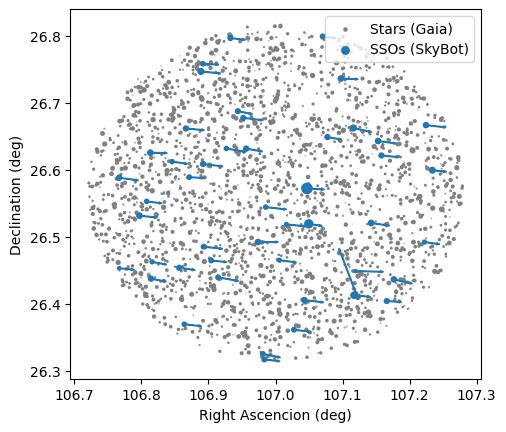

In [12]:
fig, ax = plt.subplots()

# Plot Gaia stars
ax.scatter(
    catalog["ra"],
    catalog["dec"],
    s=20 - catalog["phot_g_mean_mag"],
    color="grey",
    label="Stars (Gaia)",
)

# Plot the asteroids (size is inversely proportional to magnitude)
ax.scatter(
    data["RA"], data["DEC"], s=80 - 3 * data["VMag (mag)"], color="C0", label="SSOs (SkyBot)"
)

# Show the arrows of motion
scale = 3000  # Visual scaling factor for the arrows
for i, row in data.iterrows():
    ax.arrow(
        row["RA"],
        row["DEC"],
        row["dRA (arcsec/h)"] / scale,
        row["dDEC (arcsec/h)"] / scale,
        color="C0",
    )

# Set axes
ax.set_aspect("equal")
ax.set_xlabel("Right Ascencion (deg)")
ax.set_ylabel("Declination (deg)")
ax.legend(loc="upper right")


plt.show()

Here it is. We have easily drawn a portion of the sky, with both the stars and the Solar System objects!
So, whenever you plan to access data, check out

- if there is an API, then <kbd>[requests](https://pypi.org/project/requests/)</kbd> is your friend
- check if <kbd>[astroquery](https://astroquery.readthedocs.io/en/latest/index.html)</kbd> has already implemented a solution for you

Remember that services are made by ourselves for ourselves, as a community. Consider providing APIs to the data sets and services you produce.
(*side note: the [Vizier](https://vizier.cds.unistra.fr/viz-bin/VizieR) service of the [CDS](https://cds.unistra.fr/) is a extremely simple way to publish your data upon publication*).

**Want to practice?**

- Save the Gaia catalog to a local file.
- Color-code the Gaia star based on their intrinsic colors (B<sub>p</sub>-R<sub>p</sub>) on the plot.
- Search for Solar System objects around the coordinates (RA,Dec) = (02 13 25, +12 06 43) on 2024-01-01, with a radius of one degree. 
- Try the exercices proposed in the notebook XXX